#### Z2 HIGGS MODEL
$$
\hat{H}_{\text{Z2}} = -g \sum_{i=1}^{L-1} \hat{X}_{i,i+1} + U \sum_{i=1}^{L} \hat{n}_i^2 - J \sum_{i=1}^{L-1} \left( \hat{a}_i^\dagger \hat{Z}_{i,i+1} \hat{a}_{i+1} + \text{h.c.} \right),
$$

For $L=2$ sites this is $\hat{H}_{\text{Z2}} = -g \hat{X}_{1,2} + U\left(\hat{n}_1^2 + \hat{n}_2^2\right) - J\left(\hat{a}_1^\dagger \hat{Z}_{1,2} \hat{a}_2 + \hat{a}_2^\dagger \hat{Z}_{1,2} \hat{a}_1\right)$.

To implement this in an oscillator-qubit architecture, we can do the following:
- First term just corresponds to a qubit rotation
- Hopping term is a conditional beamsplitter between the two sites
- Onsite interaction term can be implemented using a $\text{SNAP}_i(\theta)$ gate (Choosing $\theta_k = U_{i}k^2 t$, where $k$ is the photon number corresponding to a particular Fock state, implements the onsite interaction $\hat{n}_i^2$ on the $i$ th mode.
)

In [63]:
import sys
import os

# Adjust the path based on your directory structure
module_path = os.path.abspath(os.path.join('..', '..', '..'))  # Moves three directories up
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Now you can import c2qa and other modules from bosonic-qiskit
import c2qa
import qiskit
import numpy as np
import c2qa.util as util
import matplotlib.pyplot as plt
from qiskit import ClassicalRegister, visualization, AncillaRegister, QuantumRegister, QuantumCircuit
from qiskit_aer.noise import NoiseModel, amplitude_damping_error
from qiskit.quantum_info import state_fidelity, Statevector

In [ ]:
def hopping_term(circuit, qbr, qb_index, qmr, mode1, mode2, j, delta_t, gate_time=None):
    """
    Applies the hopping term as a conditional beam splitter.

    Parameters:
        circuit (QuantumCircuit): The quantum circuit.
        qbr (QuantumRegister): Quantum register containing the gauge field qubits.
        qb_index (int): Index of the control qubit in the gauge field register.
        qmr (QumodeRegister): Quantum register containing the bosonic modes.
        mode1 (int): Index of the first bosonic mode.
        mode2 (int): Index of the second bosonic mode.
        j (float): Coupling constant for the hopping term.
        delta_t (float): Trotter time step.
        gate_time (float, optional): Duration of the gate for noise.
    """
    theta = -1j * j * delta_t
    circuit.cv_c_bs(theta, qmr[mode1], qmr[mode2], qbr[qb_index], duration=gate_time if gate_time else None)

def e_field(circuit, qbr, qb_index, g, delta_t):
    """
    Applies the electric field term to a gauge field qubit.

    Parameters:
        circuit (QuantumCircuit): The quantum circuit.
        qbr (QuantumRegister): Quantum register containing the gauge field qubits.
        qb_index (int): Index of the qubit in the gauge field register.
        g (float): Coupling constant for the electric field term.
        delta_t (float): Trotter time step.
    """
    theta = 2 * g * delta_t
    circuit.rx(theta, qbr[qb_index])

def onsite_interaction(circuit, qmr, qbr, mode, U, delta_t, gate_time, cutoff):
    """
    Applies the onsite interaction U * (n^2) using a SNAP gate.

    Parameters:
        circuit (QuantumCircuit): The quantum circuit.
        qmr (QumodeRegister): Quantum register containing the qumodes.
        qbr (QuantumRegister): Quantum register containing the qubits (if needed for conditional ops).
        mode (int): Index of the qumode for the onsite interaction.
        U (float): Interaction strength.
        delta_t (float): Time duration (t).
        gate_time (int): Duration of the SNAP gate.
        cutoff (int): Fock state cutoff.
    """
    # Generate Fock state indices [0, 1, 2, ..., cutoff-1]
    n_list = list(range(cutoff))

    # Calculate theta_k = U * k^2 * delta_t for each Fock state |k>
    theta_list = [U * (k**2) * delta_t for k in n_list]

    # Apply the SNAP gate
    # From bosonic qiskit docs:
    # If no qubit is passed,
    # then phases are applied to each qumode Fock state specified in theta and n (without
    # explicit rotation of the qubit).
 
    circuit.cv_snap(theta_list, n_list, qmr[mode], duration=gate_time)

    return circuit



In [ ]:
def simulate_z2(j=1, g=1, U=1, delta_t=0.1, noise=True, photon_loss_rate=0.0001, cond_bs_gate_time=100, snap_gate_time=100, shots=100):
    """
    Simulates a qsingle trotter step of the z2 Higgs Hamiltonian in 1+1D.

    Args:
        j (float): Coupling constant for the hopping term.
        g (float): Coupling constant for the electric field term.
        U (float): Coupling constant for the onsite interaction term.
        delta_t (float): Trotter time step.
        noise (bool): Whether to include photon loss noise in the simulation.
        photon_loss_rate (float): Photon loss rate in units of 1/ns (only relevant if noise=True).
        cond_bs_gate_time (int): Duration of the gate for the hopping term in nanoseconds.
        snap_gate_time (int): Duration of the gate for the onsite interaction term in nanoseconds.
        shots (int): Number of shots for the simulation (only relevant if noise=True).
        
    Returns:
        Statevector: If noise=True, returns a tuple of statevectors. If noise=False, returns the statevector.
    """
    # Define the number of qumodes and qubits per qumode
    num_qumodes = 2 
    num_qubits = 1
    num_qubits_per_qumode = 2  
    cutoff = 2**num_qubits_per_qumode
    
    qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
    qbr = qiskit.QuantumRegister(size=num_qubits)  # Gauge field register 

    # Create the circuit
    circuit = c2qa.CVCircuit(qmr, qbr)

    # Initialize the two qumodes in Fock state |1>
    circuit.cv_initialize(1, qmr[0])
    circuit.cv_initialize(1, qmr[1])

    # Apply operations: Hopping term, Electric field, and Onsite interaction
    hopping_term(circuit, qbr, 0, qmr, 0, 1, j, delta_t, cond_bs_gate_time)
    e_field(circuit, qbr, 0, g, delta_t)
    onsite_interaction(circuit, qmr, qbr, 0, U, delta_t, snap_gate_time, cutoff)
    onsite_interaction(circuit, qmr, qbr, 1, U, delta_t, snap_gate_time, cutoff)

    if noise:
        # Add photon loss noise
        noise_pass = c2qa.kraus.PhotonLossNoisePass(
            photon_loss_rates=photon_loss_rate, circuit=circuit, time_unit="ns"
        )
        
        # Run the simulation with noise
        state, _, _ = c2qa.util.simulate(
            circuit, shots=shots, per_shot_state_vector=True, return_fockcounts=False, noise_passes=noise_pass
        )
        return state
    else:
        # Run the simulation without noise
        state, _, _ = c2qa.util.simulate(circuit)
        return state



In [66]:
def compute_average_fidelity(g, U, J, delta_t, photon_loss_rate=0.0001, cond_bs_gate_time=100, snap_gate_time=100, shots=100):
    """
    Computes the average fidelity between the noiseless statevector and individual noisy statevectors,
    and the error from shot noise.
    
    Args:
        g (float): Electric field coupling constant.
        U (float): Onsite interaction coupling constant.
        J (float): Hopping term coupling constant.
        delta_t (float): Trotter time step.
        photon_loss_rate (float): Photon loss rate in units of 1/ns.
        cond_bs_gate_time (int): Duration of the gate for the hopping term in ns.
        snap_gate_time (int): Duration of the gate for the onsite interaction term in ns.
        shots (int): Number of shots for the noisy simulation.
        
    Returns:
        tuple: The average fidelity and the shot noise error.
    """
    # Simulate the noiseless state
    state_no_noise = simulate_z2(g=g, U=U, j=J, delta_t=delta_t, noise=False, cond_bs_gate_time=cond_bs_gate_time, snap_gate_time=snap_gate_time)
    
    # Simulate the noisy statevectors
    noisy_statevectors = simulate_z2(g=g, U=U, j=J, delta_t=delta_t, noise=True, 
                                                 photon_loss_rate=photon_loss_rate, cond_bs_gate_time=cond_bs_gate_time, 
                                                 snap_gate_time=snap_gate_time, shots=shots)
    
    # Calculate fidelity for each noisy statevector
    fidelities = [state_fidelity(state_no_noise, noisy_state) for noisy_state in noisy_statevectors]
    
    # Compute the average fidelity using numpy
    average_fidelity = np.average(fidelities)
    
    # Calculate the standard error
    std_error = np.std(fidelities) / np.sqrt(shots)
    
    return average_fidelity, std_error



In [67]:
import warnings
from scipy.sparse import SparseEfficiencyWarning

# Suppress specific warnings
warnings.filterwarnings("ignore", message="PhotonLossNoisePass ignores instructions without duration")
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)


g = 0     # Electric field coupling constant
U = 0     # Onsite interaction coupling constant
J = 1     # Hopping term coupling constant
delta_t = 1  # Trotter time step
photon_loss_rates = np.linspace(1e-4, 0.02, num=20)   # Photon loss from 10^-4 to 10^-2 (in 1/ns)
cond_bs_gate_times = [30, 100]  # Gate times for the conditional beamsplitter in ns
snap_gate_times = [25, 150]  # Gate times for the SNAP in ns
shots = 1024  # Number of shots for the noisy simulation

# Placeholder for results
results = {}

# Loop over gate times and photon loss rates
for cond_bs_gate_time in cond_bs_gate_times:
    for snap_gate_time in snap_gate_times:
        # Initialize placeholders for fidelities and errors
        fidelities = []
        errors = []
        
        for photon_loss_rate in photon_loss_rates:
            # Compute average fidelity and standard error for the current settings
            average_fidelity, std_error = compute_average_fidelity(g, U, J, delta_t, photon_loss_rate, cond_bs_gate_time, snap_gate_time, shots)
            
            # Store the results
            fidelities.append(average_fidelity)
            errors.append(std_error)
        
        # Store both fidelities and errors for the current gate time combination
        results[(cond_bs_gate_time, snap_gate_time)] = {
            'fidelities': fidelities,
            'errors': errors
        }


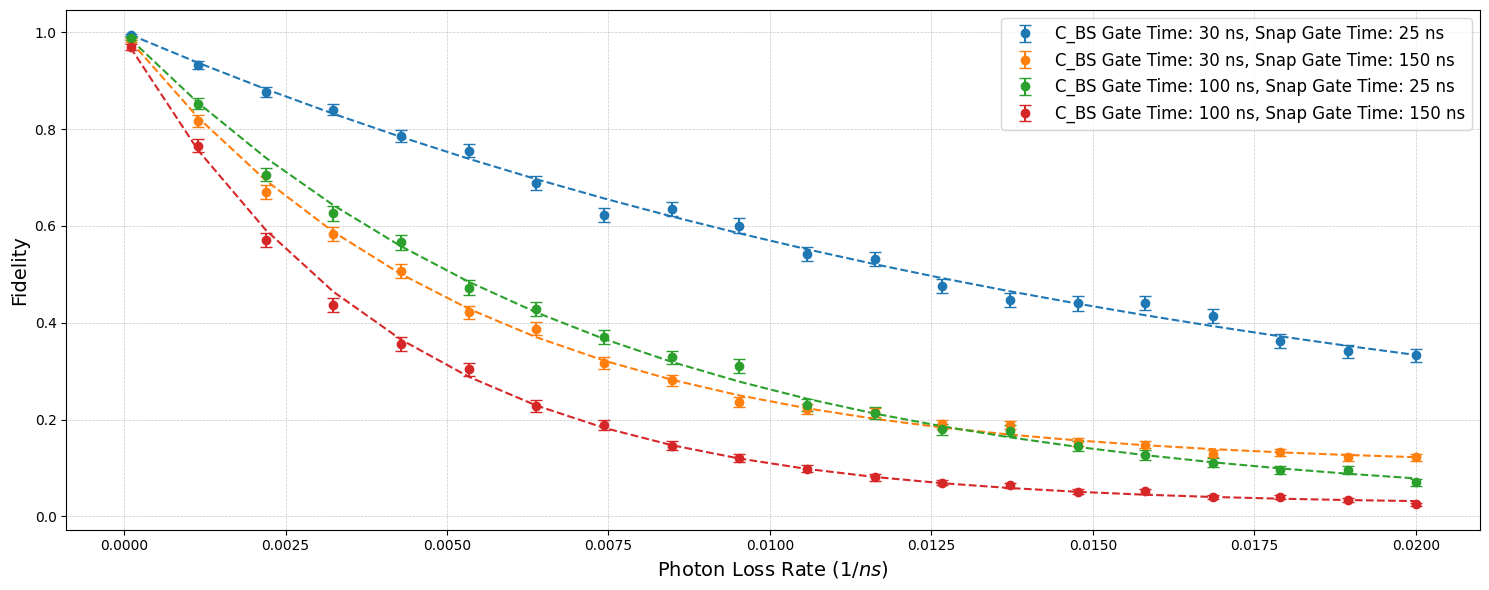

In [75]:
from scipy.optimize import curve_fit


# Define the exponential model
def exponential_model(x, a, b, c):
    return a * np.exp(-b * x) + c

# Initialize a dictionary to store fitted parameters
exponential_fits = {}

# Fit the exponential model for each combination of cond_bs_gate_time and snap_gate_time
for cond_bs_gate_time in cond_bs_gate_times:
    for snap_gate_time in snap_gate_times:
        # Extract fidelities and errors for the current gate time combination
        fidelities = np.array(results[(cond_bs_gate_time, snap_gate_time)]['fidelities'])
        errors = np.array(results[(cond_bs_gate_time, snap_gate_time)]['errors'])
        
        # Make an initial guess for the parameters
        initial_guess = [np.max(fidelities), 0.1, np.min(fidelities)] 
        
        try:
            # Perform the curve fitting
            popt, _ = curve_fit(
                exponential_model, photon_loss_rates, fidelities, sigma=errors, 
                absolute_sigma=True, p0=initial_guess, maxfev=10000
            )
            exponential_fits[(cond_bs_gate_time, snap_gate_time)] = popt
        except RuntimeError as e:
            print(f"Fitting failed for C_BS Gate Time: {cond_bs_gate_time}, Snap Gate Time: {snap_gate_time}")
            print(f"Error: {e}")
            continue

# Plotting
plt.figure(figsize=(15, 6))

# Loop over the combinations of gate times to plot data and fits
for cond_bs_gate_time in cond_bs_gate_times:
    for snap_gate_time in snap_gate_times:
        # Extract fidelities and errors for the current gate time combination
        fidelities = np.array(results[(cond_bs_gate_time, snap_gate_time)]['fidelities'])
        errors = np.array(results[(cond_bs_gate_time, snap_gate_time)]['errors'])
        
        # Plot the original data with error bars
        data_points = plt.errorbar(
            photon_loss_rates,
            fidelities,
            yerr=errors,
            fmt='o',
            capsize=4,
            label=f'C_BS Gate Time: {cond_bs_gate_time} ns, Snap Gate Time: {snap_gate_time} ns'
        )
        
        # Plot the exponential fit using the same color as the data points
        fit_params = exponential_fits.get((cond_bs_gate_time, snap_gate_time))
        if fit_params is not None:
            predicted = exponential_model(photon_loss_rates, *fit_params)
            plt.plot(
                photon_loss_rates,
                predicted,
                linestyle='--', 
                color=data_points[0].get_color()
            )

plt.xlabel('Photon Loss Rate ($1/ns$)', fontsize=14)
plt.ylabel('Fidelity', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()

plt.show()
